In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
from scipy.spatial import distance
import scvi


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(
Global seed set to 0
/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-pack

# 0. Coembedding with scvi

In [14]:
path = "../data/raw/visium/"
visium = sc.read_visium(path, genome=None, count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
                        library_id=None, load_images=True, source_image_path=None)
visium.var_names_make_unique()

/home/o313a/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [94]:
adata_seq = sc.read_h5ad("../data/interim/scrna.h5ad")

/home/o313a/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


,barcode,orig.ident,nCount_RNA,nFeature_RNA,percent.MT,percent.Ribosomal,RNA_snn_res.0.5,seurat_clusters,celltype_major,celltype_minor
AAACAAGCAAACGGGA.1,AAACAAGCAAACGGGA.1,0,1145.0,812,3.580786,0.0,1,1,4,18
AAACAAGCAAATAGGA.1,AAACAAGCAAATAGGA.1,0,8116.0,3975,2.402661,0.0,4,4,4,18
AAACAAGCAAATGACT.1,AAACAAGCAAATGACT.1,0,799.0,478,4.130163,0.0,7,7,2,8
AAACAAGCAACAAGTT.1,AAACAAGCAACAAGTT.1,0,1393.0,1104,1.507538,0.0,8,8,7,26
AAACAAGCAACCATTC.1,AAACAAGCAACCATTC.1,0,3811.0,2557,2.282865,0.0,9,9,5,21
...,...,...,...,...,...,...,...,...,...,...
TTTGTGAGTGGTTACT.1,TTTGTGAGTGGTTACT.1,0,3391.0,2278,3.184901,0.0,9,9,5,21
TTTGTGAGTGTTCCAG.1,TTTGTGAGTGTTCCAG.1,0,951.0,689,2.103049,0.0,1,1,1,3
TTTGTGAGTTACTTCT.1,TTTGTGAGTTACTTCT.1,0,14141.0,5360,4.858214,0.0,3,3,2,5
TTTGTGAGTTGTCATA.1,TTTGTGAGTTGTCATA.1,0,2870.0,1927,2.404181,0.0,6,6,2,8


In [5]:
adata_seq = adata_seq.raw.to_adata()

In [6]:
adata_seq.X.data = np.exp(adata_seq.X.data) - 1


In [7]:
adata_seq.X = adata_seq.X.multiply(adata_seq.obs.nCount_RNA.to_numpy()[:, np.newaxis]).tocsr()
adata_seq.X = np.round(adata_seq.X / 1e4)

In [8]:
adata_seq.obs.index = adata_seq.obs.index.str.replace(".", "-")

In [9]:
adata_seq.var_names_make_unique()


In [10]:
visium.var

,gene_ids,feature_types,genome
SAMD11,ENSG00000187634,Gene Expression,GRCh38
NOC2L,ENSG00000188976,Gene Expression,GRCh38
KLHL17,ENSG00000187961,Gene Expression,GRCh38
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38
PERM1,ENSG00000187642,Gene Expression,GRCh38
...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38
MT-ND4,ENSG00000198886,Gene Expression,GRCh38
MT-ND5,ENSG00000198786,Gene Expression,GRCh38
MT-ND6,ENSG00000198695,Gene Expression,GRCh38


In [11]:
visium.obs["source"] = "visium"
adata_seq.obs["source"] = "scRNA"
adata = visium.concatenate(adata_seq)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [25]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="source")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)


In [27]:
vae.train()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 229/229: 100%|██████████| 229/229 [2:51:05<00:00, 37.72s/it, loss=1.01e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=229` reached.


Epoch 229/229: 100%|██████████| 229/229 [2:51:05<00:00, 44.83s/it, loss=1.01e+03, v_num=1]


In [28]:
adata.obsm["X_scVI"] = vae.get_latent_representation()


In [31]:
from scvi.model.utils import mde
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


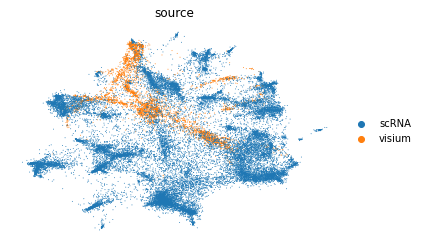

In [32]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["source"],
    frameon=False,
    ncols=1,
)


In [33]:
cell_source = pd.DataFrame(adata.obsm["X_mde"], index = adata.obs.index)
cell_source["source"] = adata.obs.source
cell_source.to_csv("../data/interim/res_scvi.csv")

In [3]:
cell_source = pd.read_csv("../data/interim/res_scvi.csv", index_col=0)

In [6]:
cell_source.head()

,0,1,source
AACACCTACTATCGAA-1-0,-0.685019,1.523659,visium
AACACGTGCATCGCAC-1-0,-0.746367,0.760773,visium
AACACTTGGCAAGGAA-1-0,0.851850,1.325718,visium
AACAGGAAGAGCATAG-1-0,-0.408944,0.579145,visium
AACAGGATTCATAGTT-1-0,-0.165718,0.560987,visium


# 1. Edges from knn based on teh embedding

In [7]:
cell_source.index = [x[:-2] for x in cell_source.index]
cell_source.source.unique()

array(['visium', 'scRNA'], dtype=object)

In [8]:
cell_source.columns

Index(['0', '1', 'source'], dtype='object')

In [9]:
emb_spatial = cell_source[cell_source.source == "visium"][['0', '1']]
emb_rna = cell_source[cell_source.source == "scRNA"][['0', '1']]

In [10]:
dist = distance.cdist(emb_rna.values, emb_spatial.values, 'euclidean')
dist = pd.DataFrame(dist, index = emb_rna.index, columns = emb_spatial.index)

In [11]:
n_neigb = 10
edges = []
locations = dist.columns
for cell in tqdm(dist.index):
    d = dist.loc[[cell]]
    t = np.sort(d.values)[:,n_neigb-1][0]
    indexer = (d<=t).values[0]
    loc_edges = [locations[i] for i in range(len(indexer)) if indexer[i]]
    for loc in loc_edges:
        edges.append((cell,loc))

100%|██████████| 29891/29891 [00:40<00:00, 733.03it/s]


In [12]:
edges = pd.DataFrame(edges)
edges.columns = ["node1", "node2"]
edges.head()

,node1,node2
0,AAACAAGCAAACGGGA-1,AATTCTCAGACGCAAC-1
1,AAACAAGCAAACGGGA-1,AGCGACCGTTCTATAC-1
2,AAACAAGCAAACGGGA-1,CTTAGTGCGTTGACGC-1
3,AAACAAGCAAACGGGA-1,GCATACTAGCATCGAA-1
4,AAACAAGCAAACGGGA-1,GCCGATCGAGTGAAGT-1


# 2. Edges from spatial data

In [15]:
coor_int = [[int(x[0]),int(x[1])] for x in visium.obsm["spatial"]]
visium.obsm["spatial"] = np.array(coor_int)

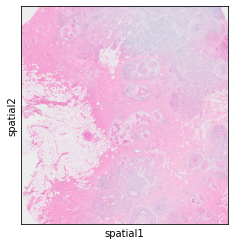

In [16]:
sc.pl.spatial(visium, img_key="hires")


In [17]:
vis_nodes = visium.obs.index

In [18]:
vis_nodes

Index(['AACACCTACTATCGAA-1', 'AACACGTGCATCGCAC-1', 'AACACTTGGCAAGGAA-1',
       'AACAGGAAGAGCATAG-1', 'AACAGGATTCATAGTT-1', 'AACAGGCCAACGATTA-1',
       'AACAGGTTATTGCACC-1', 'AACAGGTTCACCGAAG-1', 'AACAGTCAGGCTCCGC-1',
       'AACAGTCCACGCGGTG-1',
       ...
       'TGTTCGCAACCGCCAA-1', 'TGTTCGTGACCAGTAG-1', 'TGTTCTGCTCTGTCGT-1',
       'TGTTGCGTCCAAGATT-1', 'TGTTGGAACCTTCCGC-1', 'TGTTGGAACGAGGTCA-1',
       'TGTTGGAAGCTCGGTA-1', 'TGTTGGATGGACTTCT-1', 'TGTTGGCCAGACCTAC-1',
       'TGTTGGCCTACACGTG-1'],
      dtype='object', length=4992)

In [19]:
# convert array_row and array_col columns to integers in visium.obs dataframe
visium.obs["array_row"] = visium.obs["array_row"].astype(int)
visium.obs["array_col"] = visium.obs["array_col"].astype(int)


In [20]:
edges_vis = []
for node in vis_nodes:
    x= visium.obs.loc[node].array_row
    y= visium.obs.loc[node].array_col
    nodes = visium.obs[(visium.obs.array_row >=x-1)&(visium.obs.array_row <=x+1)&(visium.obs.array_col <=y+1)&(visium.obs.array_col >=y-1)].index
    for n in nodes:
        if n != node:
            edges_vis.append([node,n])

In [21]:
edges_vis = pd.DataFrame(edges_vis, columns = ["node1", "node2"])

In [22]:
edges_vis["type"] = "vis2grid"

In [23]:
edges = pd.concat([edges,edges_vis])

In [24]:
edges.type = edges.type.fillna("sc2vis")

# 3. CLones and cell types from RNA

In [25]:
cnv_pred = pd.read_csv("../data/interim/clones_sc.csv",index_col = 0)

In [26]:
cnv_pred

,leiden
cell.names,
CGCAAGGGTTAGTGAG-1,8
CAAGACTAGCTTGAGG-1,8
GCCAATACATTGCCTG-1,8
CTTCAATAGATGATTG-1,8
GATGCAAGTATTGCGT-1,8
...,...
TCTAACCCAGGTATTG-1,0
TCAACTAGTTAGCGCC-1,3
CAGGTCAAGACCATTT-1,0


In [99]:
cell_types = pd.read_csv("../data/interim/cell_types.csv", index_col = 2, sep = ";")

In [100]:
cell_types.shape

(29500, 6)

In [101]:
cell_types.index = [x.replace(".", "-") for x in cell_types.index]

In [103]:
cell_types = cell_types.join(cnv_pred)

In [104]:
cell_types = cell_types[["celltype_major","celltype_minor","leiden"]]

In [105]:
cell_types = cell_types.reset_index()

In [106]:
cell_types

,index,celltype_major,celltype_minor,leiden
0,AAACAAGCAAACGGGA-1,Myeloid,Macrophage,NaN
1,AAACAAGCAAATAGGA-1,Myeloid,Macrophage,0.0
2,AAACCAATCAAGCGAT-1,Myeloid,Macrophage,3.0
3,AAACCAATCCAATGAA-1,Myeloid,Monocyte,NaN
4,AAACCAATCGCTTCGG-1,Myeloid,Macrophage,0.0
...,...,...,...,...
29495,TTTGCCCGTACTTCCC-1,Plasmablasts,Plasmablasts,NaN
29496,TTTGCCCGTTGTGACT-1,Plasmablasts,Plasmablasts,NaN
29497,TTTGCGCAGAGGCGGA-1,Plasmablasts,Plasmablasts,NaN
29498,TTTGCTCTCATCAAGA-1,Plasmablasts,Plasmablasts,NaN


In [107]:
cell_types.columns = ["node1","celltype_major","celltype_minor","clone"]
cell_types.clone = cell_types.clone.fillna("diploid")
cell_types.clone = cell_types.clone.astype(str)

In [108]:
cell_types

,node1,celltype_major,celltype_minor,clone
0,AAACAAGCAAACGGGA-1,Myeloid,Macrophage,diploid
1,AAACAAGCAAATAGGA-1,Myeloid,Macrophage,0.0
2,AAACCAATCAAGCGAT-1,Myeloid,Macrophage,3.0
3,AAACCAATCCAATGAA-1,Myeloid,Monocyte,diploid
4,AAACCAATCGCTTCGG-1,Myeloid,Macrophage,0.0
...,...,...,...,...
29495,TTTGCCCGTACTTCCC-1,Plasmablasts,Plasmablasts,diploid
29496,TTTGCCCGTTGTGACT-1,Plasmablasts,Plasmablasts,diploid
29497,TTTGCGCAGAGGCGGA-1,Plasmablasts,Plasmablasts,diploid
29498,TTTGCTCTCATCAAGA-1,Plasmablasts,Plasmablasts,diploid


In [109]:
edges_tmp = edges.copy()

In [110]:
edges_tmp

,node1,node2,type
0,AAACAAGCAAACGGGA-1,AATTCTCAGACGCAAC-1,sc2vis
1,AAACAAGCAAACGGGA-1,AGCGACCGTTCTATAC-1,sc2vis
2,AAACAAGCAAACGGGA-1,CTTAGTGCGTTGACGC-1,sc2vis
3,AAACAAGCAAACGGGA-1,GCATACTAGCATCGAA-1,sc2vis
4,AAACAAGCAAACGGGA-1,GCCGATCGAGTGAAGT-1,sc2vis
...,...,...,...
19553,TGTTGGCCAGACCTAC-1,GATGGACCTGGACGGA-1,vis2grid
19554,TGTTGGCCAGACCTAC-1,GGTAGCTTAGCCAATC-1,vis2grid
19555,TGTTGGCCAGACCTAC-1,TCATCTCCAACCACCT-1,vis2grid
19556,TGTTGGCCTACACGTG-1,AGGATCGAGCACCGCC-1,vis2grid


In [111]:
edges_tmp = edges_tmp.merge(cell_types, left_on = "node1", right_on = "node1", how = "left")

In [112]:
edges_tmp[edges_tmp.type == "vis2grid"]

,node1,node2,type,celltype_major,celltype_minor,clone
298910,AACACCTACTATCGAA-1,ATGAGTAGCGTGTTAG-1,vis2grid,NaN,NaN,NaN
298911,AACACCTACTATCGAA-1,GTCGAACCGTTCACTC-1,vis2grid,NaN,NaN,NaN
298912,AACACGTGCATCGCAC-1,AGGTACGGAAGTCAAC-1,vis2grid,NaN,NaN,NaN
298913,AACACGTGCATCGCAC-1,GCCTTCGATCAGGTCG-1,vis2grid,NaN,NaN,NaN
298914,AACACGTGCATCGCAC-1,GGTGCAACCATGAGGA-1,vis2grid,NaN,NaN,NaN
...,...,...,...,...,...,...
318463,TGTTGGCCAGACCTAC-1,GATGGACCTGGACGGA-1,vis2grid,NaN,NaN,NaN
318464,TGTTGGCCAGACCTAC-1,GGTAGCTTAGCCAATC-1,vis2grid,NaN,NaN,NaN
318465,TGTTGGCCAGACCTAC-1,TCATCTCCAACCACCT-1,vis2grid,NaN,NaN,NaN
318466,TGTTGGCCTACACGTG-1,AGGATCGAGCACCGCC-1,vis2grid,NaN,NaN,NaN


In [113]:
edges_tmp

,node1,node2,type,celltype_major,celltype_minor,clone
0,AAACAAGCAAACGGGA-1,AATTCTCAGACGCAAC-1,sc2vis,Myeloid,Macrophage,diploid
1,AAACAAGCAAACGGGA-1,AGCGACCGTTCTATAC-1,sc2vis,Myeloid,Macrophage,diploid
2,AAACAAGCAAACGGGA-1,CTTAGTGCGTTGACGC-1,sc2vis,Myeloid,Macrophage,diploid
3,AAACAAGCAAACGGGA-1,GCATACTAGCATCGAA-1,sc2vis,Myeloid,Macrophage,diploid
4,AAACAAGCAAACGGGA-1,GCCGATCGAGTGAAGT-1,sc2vis,Myeloid,Macrophage,diploid
...,...,...,...,...,...,...
318463,TGTTGGCCAGACCTAC-1,GATGGACCTGGACGGA-1,vis2grid,NaN,NaN,NaN
318464,TGTTGGCCAGACCTAC-1,GGTAGCTTAGCCAATC-1,vis2grid,NaN,NaN,NaN
318465,TGTTGGCCAGACCTAC-1,TCATCTCCAACCACCT-1,vis2grid,NaN,NaN,NaN
318466,TGTTGGCCTACACGTG-1,AGGATCGAGCACCGCC-1,vis2grid,NaN,NaN,NaN


In [116]:
to_drop = np.where(edges_tmp[edges_tmp.type == "sc2vis"].celltype_major.isna() == True)[0]

In [118]:
to_drop = edges_tmp[(edges_tmp.type == "sc2vis") & edges_tmp.celltype_major.isna()].index

Index([   250,    251,    252,    253,    254,    255,    256,    257,    258,
          259,
       ...
       297690, 297691, 297692, 297693, 297694, 297695, 297696, 297697, 297698,
       297699],
      dtype='int64', length=8040)

In [121]:
edges_tmp = edges_tmp.drop(to_drop, axis=0)


In [122]:
edges_tmp.to_csv("../data/interim/edges.csv")

In [75]:
emb_spatial.to_csv("../data/interim/embedding_visium_scvi.csv")
emb_rna.to_csv("../data/interim/embedding_rna2vis_scvi.csv")